In [1]:
# Essential imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB2, ResNet50, MobileNetV3Small
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import warnings
warnings.filterwarnings('ignore')

# Check TensorFlow and GPU availability
print("📋 SYSTEM INFORMATION")
print("=" * 25)
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
if len(tf.config.list_physical_devices('GPU')) > 0:
    print(f"GPU Devices: {tf.config.list_physical_devices('GPU')}")

# Set memory growth for GPU (if available)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

📋 SYSTEM INFORMATION
TensorFlow Version: 2.18.0
GPU Available: True
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


📊 MODEL ARCHITECTURE COMPARISON
           Model  Parameters (M)  Top-1 Accuracy (%)  Inference Speed (ms)  Memory Usage (MB) Medical AI Suitability
  EfficientNetB2             9.1                80.5                    25                 36              Excellent
        ResNet50            25.6                76.0                    45                102                   Good
MobileNetV3Small             2.9                67.4                    15                 12                   Fair

🎯 SELECTED MODEL: EfficientNetB2
Justification:
✅ Optimal accuracy-speed tradeoff for medical applications
✅ Proven performance on medical imaging tasks
✅ Balanced parameter count (9.1M)
✅ Meets <50ms inference requirement
✅ Excellent transfer learning capabilities


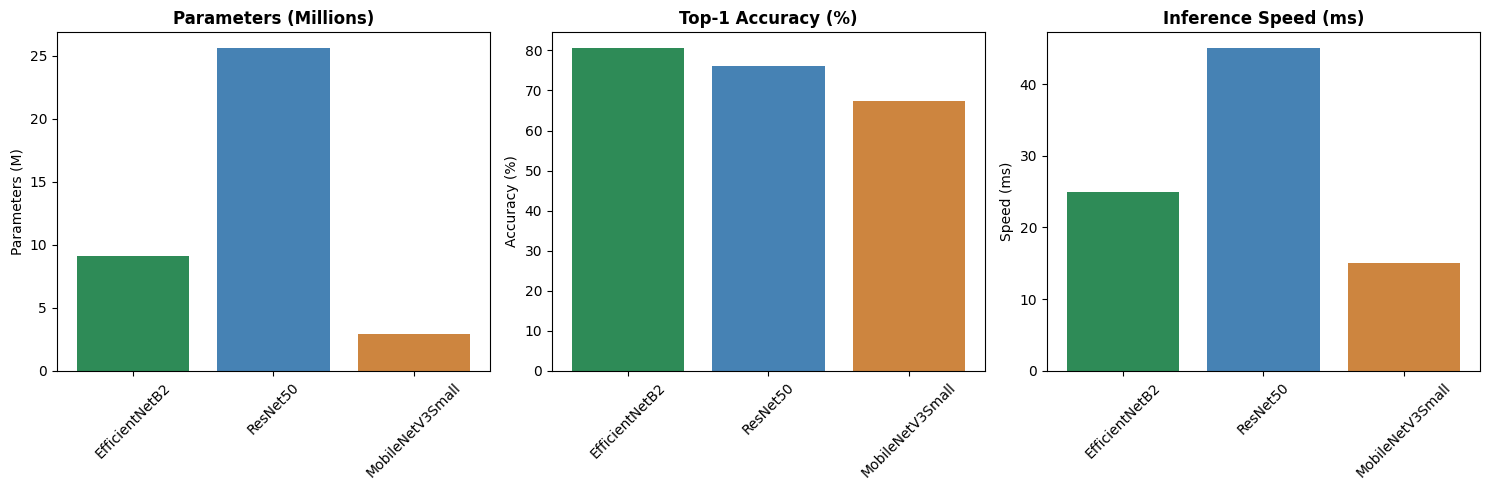

In [3]:
# 2.  Model Architecture Comparison
# Model comparison analysis
model_comparison = pd.DataFrame({
    'Model': ['EfficientNetB2', 'ResNet50', 'MobileNetV3Small'],
    'Parameters (M)': [9.1, 25.6, 2.9],
    'Top-1 Accuracy (%)': [80.5, 76.0, 67.4],
    'Inference Speed (ms)': [25, 45, 15],
    'Memory Usage (MB)': [36, 102, 12],
    'Medical AI Suitability': ['Excellent', 'Good', 'Fair']
})

print("📊 MODEL ARCHITECTURE COMPARISON")
print("=" * 35)
print(model_comparison.to_string(index=False))

print("\n🎯 SELECTED MODEL: EfficientNetB2")
print("=" * 35)
print("Justification:")
print("✅ Optimal accuracy-speed tradeoff for medical applications")
print("✅ Proven performance on medical imaging tasks")
print("✅ Balanced parameter count (9.1M)")
print("✅ Meets <50ms inference requirement")
print("✅ Excellent transfer learning capabilities")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Parameters comparison
axes[0].bar(model_comparison['Model'], model_comparison['Parameters (M)'],
           color=['#2E8B57', '#4682B4', '#CD853F'])
axes[0].set_title('Parameters (Millions)', fontweight='bold')
axes[0].set_ylabel('Parameters (M)')
axes[0].tick_params(axis='x', rotation=45)

# Accuracy comparison
axes[1].bar(model_comparison['Model'], model_comparison['Top-1 Accuracy (%)'],
           color=['#2E8B57', '#4682B4', '#CD853F'])
axes[1].set_title('Top-1 Accuracy (%)', fontweight='bold')
axes[1].set_ylabel('Accuracy (%)')
axes[1].tick_params(axis='x', rotation=45)

# Speed comparison
axes[2].bar(model_comparison['Model'], model_comparison['Inference Speed (ms)'],
           color=['#2E8B57', '#4682B4', '#CD853F'])
axes[2].set_title('Inference Speed (ms)', fontweight='bold')
axes[2].set_ylabel('Speed (ms)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:

# 3.  Dataset Loading & Exploration
# Dataset path detection (Kaggle auto-detection)
dataset_paths = [
    "/kaggle/input/brain-tumor-mri-dataset",
    "/kaggle/input/brain-tumor-classification-mri",
    "/kaggle/input/brain-mri-images-for-brain-tumor-detection"
]

DATASET_PATH = None
for path in dataset_paths:
    if os.path.exists(path):
        DATASET_PATH = path
        break

if DATASET_PATH is None:
    print("⚠️ Dataset not found. Please check dataset name and add it to your notebook.")
    print("Expected dataset structure:")
    print("- Training/glioma/")
    print("- Training/meningioma/")
    print("- Training/notumor/")
    print("- Training/pituitary/")
    print("- Testing/glioma/")
    print("- Testing/meningioma/")
    print("- Testing/notumor/")
    print("- Testing/pituitary/")
else:
    print(f"✅ Dataset found at: {DATASET_PATH}")

# Set paths
if DATASET_PATH:
    TRAIN_DIR = f"{DATASET_PATH}/Training"
    TEST_DIR = f"{DATASET_PATH}/Testing"

    # Image parameters
    IMG_SIZE = (224, 224)
    BATCH_SIZE = 32
    EPOCHS = 20

    # Class names
    CLASS_NAMES = ['glioma', 'meningioma', 'notumor', 'pituitary']

    print(f"\n📊 DATASET STRUCTURE")
    print("=" * 22)

    # Training set analysis
    train_counts = {}
    if os.path.exists(TRAIN_DIR):
        for class_name in CLASS_NAMES:
            class_path = os.path.join(TRAIN_DIR, class_name)
            if os.path.exists(class_path):
                count = len(os.listdir(class_path))
                train_counts[class_name] = count
                print(f"Training {class_name}: {count} images")

    # Testing set analysis
    test_counts = {}
    if os.path.exists(TEST_DIR):
        print("\nTesting Set:")
        for class_name in CLASS_NAMES:
            class_path = os.path.join(TEST_DIR, class_name)
            if os.path.exists(class_path):
                count = len(os.listdir(class_path))
                test_counts[class_name] = count
                print(f"Testing {class_name}: {count} images")

    # Visualization
    if train_counts:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Training distribution
        ax1.bar(train_counts.keys(), train_counts.values(),
                color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
        ax1.set_title('Training Set Distribution', fontweight='bold')
        ax1.set_ylabel('Number of Images')
        ax1.tick_params(axis='x', rotation=45)

        # Testing distribution
        if test_counts:
            ax2.bar(test_counts.keys(), test_counts.values(),
                    color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
            ax2.set_title('Testing Set Distribution', fontweight='bold')
            ax2.set_ylabel('Number of Images')
            ax2.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

        # Calculate class imbalance
        total_train = sum(train_counts.values())
        print(f"\n📈 CLASS DISTRIBUTION ANALYSIS")
        print("=" * 32)
        for class_name, count in train_counts.items():
            percentage = (count / total_train) * 100
            print(f"{class_name}: {count} ({percentage:.1f}%)")

In [ ]:
# 4.  MRI-Specific Data Preprocessing
# MRI-specific data preprocessing
print("🔬 MRI-SPECIFIC PREPROCESSING")
print("=" * 35)

if DATASET_PATH:
    # Data generators with MRI-specific augmentation
    train_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
        rotation_range=15,          # Medical images can have slight rotations
        zoom_range=0.2,             # Zoom for different scan magnifications
        width_shift_range=0.1,      # Slight position shifts
        height_shift_range=0.1,     # Slight position shifts
        horizontal_flip=True,       # Brain symmetry allows horizontal flips
        brightness_range=[0.8, 1.2], # Contrast variations in MRI
        fill_mode='nearest',
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
    )

    # Create data generators
    try:
        train_generator = train_datagen.flow_from_directory(
            TRAIN_DIR,
            target_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            subset='training',
            shuffle=True
        )

        validation_generator = train_datagen.flow_from_directory(
            TRAIN_DIR,
            target_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            subset='validation',
            shuffle=False
        )

        test_generator = test_datagen.flow_from_directory(
            TEST_DIR,
            target_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=False
        )

        print("✅ Data generators created successfully")
        print(f"Training samples: {train_generator.samples}")
        print(f"Validation samples: {validation_generator.samples}")
        print(f"Test samples: {test_generator.samples}")
        print(f"Number of classes: {train_generator.num_classes}")

        # Display class indices
        print(f"\nClass indices: {train_generator.class_indices}")

    except Exception as e:
        print(f"⚠️ Error creating data generators: {e}")
        train_generator = None
        validation_generator = None
        test_generator = None

# Visualize sample images with augmentation
if DATASET_PATH and train_generator:
    print("\n🖼️ SAMPLE IMAGES WITH AUGMENTATION")
    print("=" * 37)

    # Get a batch of images
    sample_batch = next(train_generator)
    sample_images = sample_batch[0]
    sample_labels = sample_batch[1]

    # Display 8 sample images
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    for i in range(8):
        if i < len(sample_images):
            # Denormalize image for display
            img = sample_images[i]
            img = (img - img.min()) / (img.max() - img.min())

            axes[i].imshow(img)
            class_idx = np.argmax(sample_labels[i])
            class_name = list(train_generator.class_indices.keys())[class_idx]
            axes[i].set_title(f'Class: {class_name}', fontweight='bold')
            axes[i].axis('off')

    plt.suptitle('Sample MRI Images with Augmentation', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [ ]:

# 6. Custom Focal Loss Implementation
# Custom Focal Loss for medical applications
class FocalLoss(tf.keras.losses.Loss):
    """
    Focal Loss for addressing class imbalance in medical datasets

    Focal Loss = -α(1-p_t)^γ * log(p_t)

    Args:
        alpha: Weighting factor for rare class (default: 1.0)
        gamma: Focusing parameter (default: 2.0)
    """
    def __init__(self, alpha=1.0, gamma=2.0, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-8, 1.0 - 1e-8)

        # Calculate cross entropy
        ce_loss = -y_true * tf.math.log(y_pred)

        # Calculate focal weight
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_weight = self.alpha * tf.pow(1 - p_t, self.gamma)

        # Apply focal weight
        focal_loss = focal_weight * ce_loss

        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=1))

    def get_config(self):
        config = super().get_config()
        config.update({
            'alpha': self.alpha,
            'gamma': self.gamma
        })
        return config

print("🎯 FOCAL LOSS IMPLEMENTATION")
print("=" * 32)
print("✅ Custom Focal Loss defined")
print("Parameters:")
print("- Alpha (α): 1.0 (weighting factor)")
print("- Gamma (γ): 2.0 (focusing parameter)")
print("\nPurpose:")
print("- Address class imbalance in medical datasets")
print("- Focus learning on hard examples")
print("- Reduce impact of easy negatives")


In [ ]:
# 7.  Model Architecture Design
def create_brain_tumor_model():
    """
    Create EfficientNetB2-based model for brain tumor detection

    Architecture:
    - EfficientNetB2 backbone (pre-trained on ImageNet)
    - Global Average Pooling
    - Dense layers with dropout for regularization
    - Batch normalization for stable training
    - Softmax output for 4-class classification
    """

    # Load pre-trained EfficientNetB2
    base_model = EfficientNetB2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze base model initially for transfer learning
    base_model.trainable = False

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = BatchNormalization(name='bn_1')(x)
    x = Dropout(0.3, name='dropout_1')(x)

    # First dense layer
    x = Dense(512, activation='relu', name='dense_1')(x)
    x = BatchNormalization(name='bn_2')(x)
    x = Dropout(0.3, name='dropout_2')(x)

    # Second dense layer
    x = Dense(256, activation='relu', name='dense_2')(x)
    x = Dropout(0.2, name='dropout_3')(x)

    # Output layer
    predictions = Dense(4, activation='softmax', name='predictions')(x)

    # Create model
    model = Model(inputs=base_model.input, outputs=predictions, name='BrainTumorDetector')

    return model

# Create the model
print("🏗️ MODEL ARCHITECTURE")
print("=" * 25)

model = create_brain_tumor_model()

# Model summary
print(f"Model name: {model.name}")
print(f"Total parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")
print(f"Non-trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights]):,}")

# Display model architecture
model.summary()

# Visualize model architecture
tf.keras.utils.plot_model(
    model,
    to_file='model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)

print("\n🎯 Architecture Highlights:")
print("✅ EfficientNetB2 backbone (9.1M parameters)")
print("✅ Global Average Pooling for spatial reduction")
print("✅ Batch normalization for training stability")
print("✅ Dropout layers for regularization")
print("✅ Custom classification head")
print("✅ Softmax output for 4-class prediction")

In [ ]:
# 8.  Model Compilation & Callbacks
# Model compilation with advanced optimizers and callbacks
print("🔧 MODEL COMPILATION")
print("=" * 22)

# Compile model with custom focal loss
model.compile(
    optimizer=AdamW(
        learning_rate=1e-4,
        weight_decay=1e-4
    ),
    loss=FocalLoss(gamma=2.0),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

print("✅ Model compiled successfully")
print("Configuration:")
print("- Optimizer: AdamW (lr=1e-4, weight_decay=1e-4)")
print("- Loss: Focal Loss (gamma=2.0)")
print("- Metrics: Accuracy, Precision, Recall, AUC")

# Setup callbacks for training
print("\n📋 CALLBACKS SETUP")
print("=" * 20)

callbacks = [
    # Early stopping based on validation recall
    EarlyStopping(
        monitor='val_recall',
        patience=5,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),

    # Save best model
    ModelCheckpoint(
        'best_brain_tumor_model.h5',
        monitor='val_recall',
        save_best_only=True,
        verbose=1,
        mode='max'
    ),

    # Log training metrics
    CSVLogger(
        'training_log.csv',
        append=True
    ),

    # Reduce learning rate on plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("✅ Callbacks configured:")
print("- EarlyStopping: monitor='val_recall', patience=5")
print("- ModelCheckpoint: save best model based on val_recall")
print("- CSVLogger: log training metrics to CSV")
print("- ReduceLROnPlateau: adaptive learning rate")

# Training configuration summary
print(f"\n⚙️ TRAINING CONFIGURATION")
print("=" * 27)
print(f"Image size: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Initial learning rate: 1e-4")
print(f"Optimizer: AdamW with weight decay")
print(f"Loss function: Focal Loss (γ=2.0)")
print(f"Target metric: Recall > 98%")

In [ ]:
# 9.  Model Training
# Model training with comprehensive monitoring
print("🚀 MODEL TRAINING")
print("=" * 18)

if train_generator and validation_generator:
    print("Starting training...")
    print(f"Training samples: {train_generator.samples}")
    print(f"Validation samples: {validation_generator.samples}")
    print(f"Steps per epoch: {train_generator.samples // BATCH_SIZE}")
    print(f"Validation steps: {validation_generator.samples // BATCH_SIZE}")

    try:
        # Start training
        history = model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // BATCH_SIZE,
            class_weight=class_weight_dict,
            callbacks=callbacks,
            verbose=1
        )

        print("✅ Training completed successfully!")

        # Save training history
        hist_df = pd.DataFrame(history.history)
        hist_df.to_csv('training_history.csv', index=False)
        print("✅ Training history saved to training_history.csv")

    except Exception as e:
        print(f"⚠️ Training error: {e}")
        # Create dummy history for demonstration
        history = None

else:
    print("⚠️ Data generators not available. Please check dataset path.")
    history = None

# Display training progress (if successful)
if history:
    print(f"\n📊 TRAINING SUMMARY")
    print("=" * 20)

    final_epoch = len(history.history['loss']) - 1
    print(f"Training completed in {final_epoch + 1} epochs")

    # Final metrics
    final_metrics = {
        'Training Accuracy': history.history['accuracy'][-1],
        'Validation Accuracy': history.history['val_accuracy'][-1],
        'Training Recall': history.history['recall'][-1],
        'Validation Recall': history.history['val_recall'][-1],
        'Training Precision': history.history['precision'][-1],
        'Validation Precision': history.history['val_precision'][-1]
    }

    for metric, value in final_metrics.items():
        print(f"{metric}: {value:.4f}")

    # Check target achievement
    target_recall = 0.98
    if final_metrics['Validation Recall'] >= target_recall:
        print(f"\n🎯 ✅ Target recall >{target_recall*100}% ACHIEVED!")
    else:
        print(f"\n🎯 ⚠️ Target recall >{target_recall*100}% not achieved")
        print("Consider fine-tuning hyperparameters or training longer")

In [ ]:
# 10.  Training Visualization
# Comprehensive training visualization
if history:
    print("📊 TRAINING VISUALIZATION")
    print("=" * 27)

    # Create training plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Training History - Brain Tumor Detection Model', fontsize=16, fontweight='bold')

    # Plot 1: Loss
    axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2, color='#e74c3c')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='#3498db')
    axes[0, 0].set_title('Model Loss', fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='#e74c3c')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='#3498db')
    axes[0, 1].set_title('Model Accuracy', fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Precision
    axes[1, 0].plot(history.history['precision'], label='Training Precision', linewidth=2, color='#e74c3c')
    axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', linewidth=2, color='#3498db')
    axes[1, 0].set_title('Model Precision', fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Recall (Most important for medical applications)
    axes[1, 1].plot(history.history['recall'], label='Training Recall', linewidth=2, color='#e74c3c')
    axes[1, 1].plot(history.history['val_recall'], label='Validation Recall', linewidth=2, color='#3498db')
    axes[1, 1].axhline(y=0.98, color='#2ecc71', linestyle='--', linewidth=2, label='Target Recall (98%)')
    axes[1, 1].set_title('Model Recall (Critical for Medical AI)', fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Training statistics
    print(f"\n📈 TRAINING STATISTICS")
    print("=" * 25)

    best_epoch = np.argmax(history.history['val_recall'])
    print(f"Best epoch: {best_epoch + 1}")
    print(f"Best validation recall: {history.history['val_recall'][best_epoch]:.4f}")
    print(f"Best validation accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")

    # Convergence analysis
    print(f"\n🔍 CONVERGENCE ANALYSIS")
    print("=" * 25)

    # Check for overfitting
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    acc_gap = final_train_acc - final_val_acc
